<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/computer_vision/tensorflow_hub/tf_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning z użyciem Tensorflow Hub

### Import bibliotek

In [31]:
%tensorflow_version 2.x
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print(f'Tensorflow version: {tf.__version__}')
print(f'Tensorflow Hub version: {hub.__version__}')

Tensorflow version: 2.1.0-rc1
Tensorflow Hub version: 0.7.0


### Załadowanie modelu

In [0]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Załadowanie etykiet

In [4]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
imagenet_labels

array(['background', 'tench', 'goldfish', ..., 'bolete', 'ear',
       'toilet tissue'], dtype='<U30')

### Załadowanie obrazu

In [15]:
from google.colab import files
uploaded = files.upload()

Saving notebook.jpg to notebook.jpg


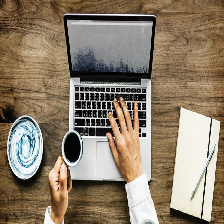

In [16]:
filename = list(uploaded.keys())[0]
img = Image.open(filename).resize(IMAGE_SHAPE)
img

### Predykcja na podstawie modelu

In [17]:
img_arr = np.array(img) / 255.
img_arr = np.expand_dims(img_arr, axis=0)
result = classifier.predict(img_arr)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name

'notebook'

### Wyświetlenie predykcji

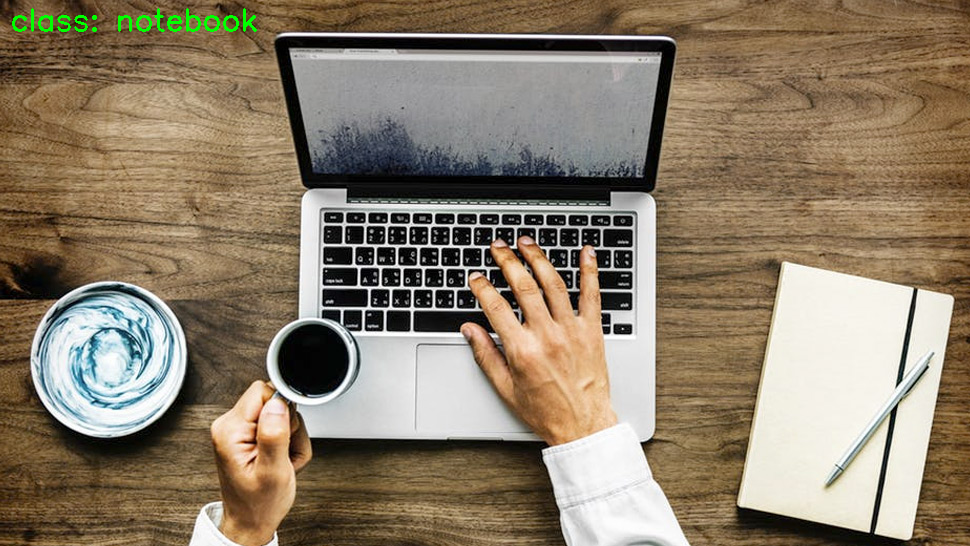

In [20]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread(filename)
text = f'class: {predicted_class_name}'
img = cv2.putText(img=img, text=text, org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                  fontScale=1, color=(0, 255, 0), thickness=2)
cv2_imshow(img)

### Transfer Learning

In [0]:
%%bash
wget -q https://storage.googleapis.com/esmartdata-courses-files/opencv-python/images.zip
unzip -q images.zip

In [22]:
# budowa generatora
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory('images', target_size=IMAGE_SHAPE)

# pobieranie wsadu danych
for image_batch, label_batch in image_data:
  print('Image batch shape: ', image_batch.shape)
  print('Label batch shape: ', image_batch.shape)
  break

# predykcja
result_batch = classifier.predict(image_batch)

# wyświetlenie klas
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

Found 1113 images belonging to 2 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 224, 224, 3)


array(['lion', 'Rhodesian ridgeback', 'Australian terrier', 'Great Dane',
       'Arabian camel', 'lion', 'Arabian camel', 'borzoi', 'worm fence',
       'ram', 'cuirass', 'ice bear', 'Doberman', 'sorrel', 'ski',
       'Arabian camel', 'teddy', 'teddy', 'white wolf',
       'African elephant', 'lion', 'bathing cap', 'flat-coated retriever',
       'Arabian camel', 'cuirass', 'lion', 'feather boa', 'lion',
       'Indian elephant', 'sorrel', 'snowmobile', 'Great Dane'],
      dtype='<U30')

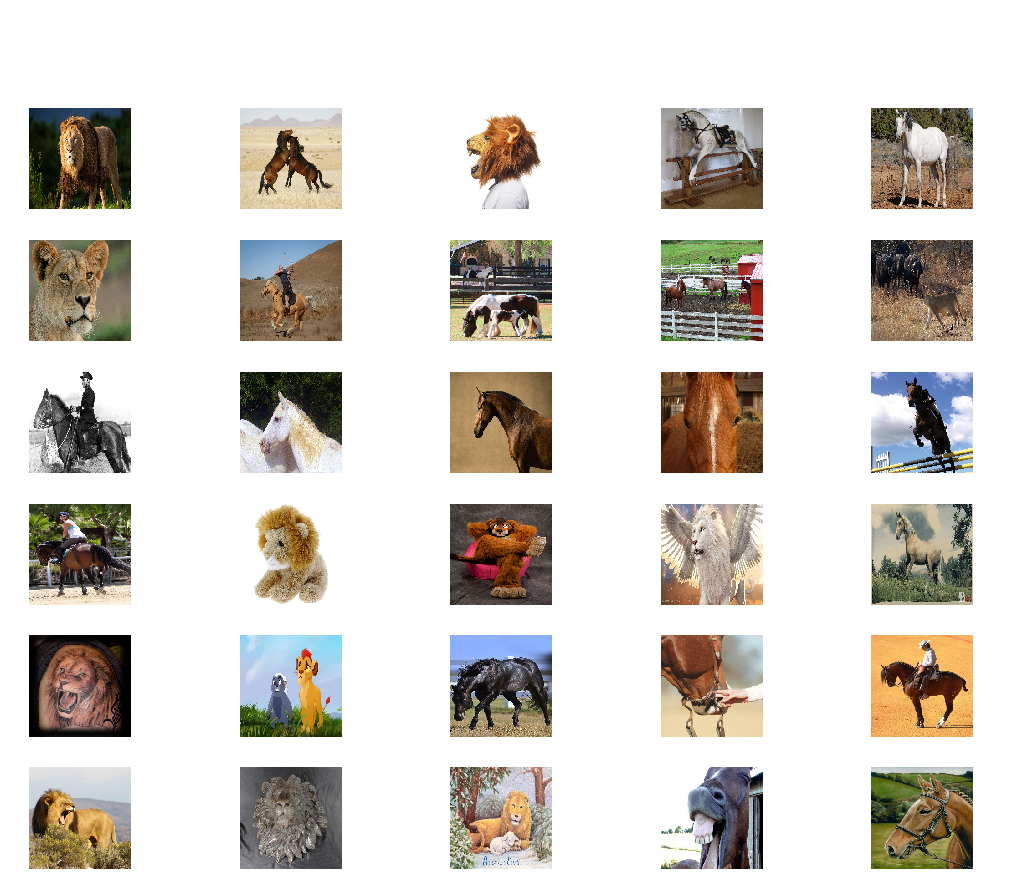

In [24]:
plt.figure(figsize=(18, 14))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n], color='white', fontdict={'fontsize': 20})
  plt.axis('off')
  plt.suptitle('ImageNet predictions', color='white', fontsize=20)

Wykorzystamy teraz tzw. ekstraktor cech (model bez ostatniej warstwy klasyfikacyjnej). Pozwala to na łatwe użycie poprzez dołączenie swojej ostatniej warstwy.

In [25]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url,
    input_shape=IMAGE_SHAPE+(3,)
)

# zamrażamy wagi ekstraktora
feature_extractor_layer.trainable = False

# budujemy model dokładając ostatnią warstwę klasyfikacji
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# zbudujemy niestandardowy Callback, aby rejestrować stratę (loss) i dokładność (accuracy) po każdym wsadzie (batch)
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [29]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=3,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 35.0 steps
Epoch 1/3
 6/35 [====>.........................] - ETA: 41s - loss: 0.0976 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


35/35 [==============================] - 48s 1s/step - loss: 0.1090 - acc: 0.9062
Epoch 2/3
35/35 [==============================] - 48s 1s/step - loss: 0.0873 - acc: 1.0000
Epoch 3/3
35/35 [==============================] - 48s 1s/step - loss: 0.0713 - acc: 0.9688


In [36]:
import pandas as pd
import plotly.graph_objects as go

def plot_hist(batch_stats_callback):
  hist = pd.DataFrame({'loss': batch_stats_callback.batch_losses,
                       'accuracy': batch_stats_callback.batch_acc})
  hist['batch'] = hist.index
  hist['batch'] += 1

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['batch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
  fig.update_layout(width=800, height=400, title='accuracy', xaxis_title='batches', yaxis_title='accuracy', yaxis_type='log')
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['batch'], y=hist['loss'], name='loss', mode='markers+lines'))
  fig.update_layout(width=800, height=400, title='loss', xaxis_title='batches', yaxis_title='loss', yaxis_type='log')
  fig.show()

plot_hist(batch_stats_callback)

In [37]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Horse', 'Lion'], dtype='<U5')

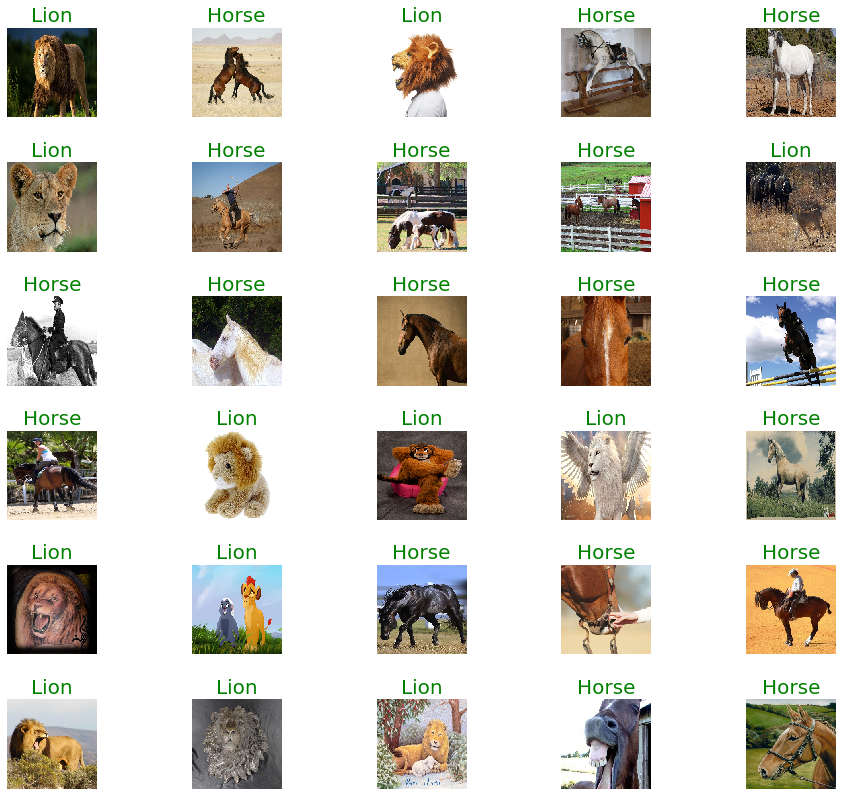

In [40]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(16, 14))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(), color=color, fontdict={'fontsize': 20})
  plt.axis('off')

In [41]:
model.save('models/model_name', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: models/model_name/assets


INFO:tensorflow:Assets written to: models/model_name/assets
